## X-ray spectral synthesis script (Herman Lee 09/2021)

### Edited for bulk use (Travis Court 02/2022)

Prerequisites: ATOMDB, pyatomdb, numpy, scipy, matplotlib

#### The uniform files have already corrected for luminosity errors. They are in [ph/s] not [ph/s/keV]


In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline


## Plotting

I'm trying to emulate Hector's plots because I am re-creating his analysis. The key values that Hector plots are Flux [$\mathrm{counts\ s^{-1} keV^{-1}}$] and Fe K $\alpha$ luminosity [$10^{40} ph\, s^{-1}$]

To keep things in line with Hector's analysis (2/16/22)
we divide the `lum_ej` and `lum_csm` by `dE` [keV]

<ipython-input-279-ea9e101e2053>:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cont = np.polyfit(Ec[mask], flux_ej[mask], 3)


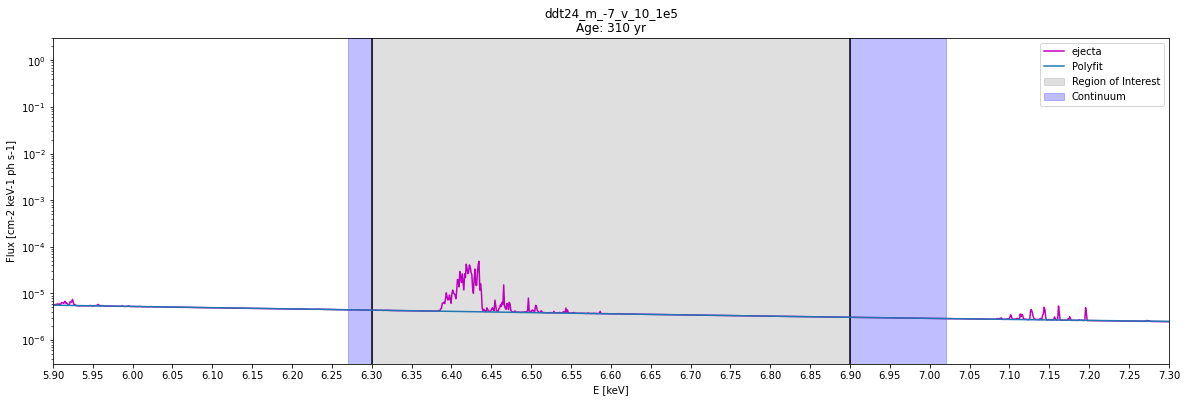

ddt24_m_-7_v_10_1e5 Age: 310 yr 6.424703 [keV] 9.264372e-01 [10^40 ph/s] , -0.191066


In [279]:
exp   = 'ddt24'
mdot  = '-7'
vwind = '10'
cavity = f'm_{mdot}_v_{vwind}_1e5'
raw_dE = 1e-3 # bin size [keV], I done goof'd
norm = 4*np.pi*(3.086e+22)**2
path = os.getcwd() + '/'+ exp + '_' + cavity +'/' #* Change this based on your directory
datfile = 1006

infile  = path + 'snr_Ia_prof_a_' + str(datfile) + '.dat' #Input file: any Lagrangian profile from ChN
outfile = path + 'sed_raw_' + str(datfile) + '.dat'

dat = np.loadtxt(outfile)
Ec  = dat[:,0]
lum_ej = dat[:,1] 
lum_csm = dat[:,2] 
lum = dat[:,3] 
flux_ej = lum / norm

age_yr = np.loadtxt(infile)[0,1]

#Creating the subtraction for Centroids
plt.figure(figsize=(20,6))
plt.plot(Ec,flux_ej,'m-',label='ejecta') # ph/s/keV
# plt.plot(Ec,lum/norm,'m-',label='ejecta') # ph/s/keV
plt.title(f'{exp}_m_{mdot}_v_{vwind}_1e5\nAge: {age_yr:.0f} yr') 
plt.ylabel('Flux [cm-2 keV-1 ph s-1]')
plt.xlabel('E [keV]')
plt.yscale('log')
plt.xscale('linear')
plt.axvspan(6.3,6.9,color='gray',alpha=0.25,label='Region of Interest')
plt.axvline(6.3,c='k')
plt.axvline(6.9,c='k')
plt.xticks(np.arange(5,8, step=0.05)) 

mask1 = 6.27
mask2 = 6.3
mask3 = 6.9
mask4 = 7.02

mask = [((Ec >= mask1) & (Ec < mask2)) | ((Ec > mask3) & (Ec <= mask4)) ]
plt.axvspan(mask1,mask2,color='blue',alpha=0.25,label='Continuum')
plt.axvspan(mask3,mask4,color='blue',alpha=0.25)#,label='Continuum')

cont = np.polyfit(Ec[mask], flux_ej[mask], 3)

continuum = np.poly1d(cont)
sub_ej = (flux_ej[ (Ec > 6.3) & (Ec < 6.9) ]) - continuum(Ec[ (Ec > 6.3) & (Ec < 6.9) ])
# sub_ej_spline = (flux_ej[ (Ec > 6.3) & (Ec < 6.9) ]) - splinecont(Ec[ (Ec > 6.3) & (Ec < 6.9) ])
plt.plot(Ec,continuum(Ec),label='Polyfit')
plt.legend(loc=0)
plt.xlim(5.9,7.3)
# plt.ylim(1e-10,1e-6)
plt.show()
#Once you have comfirmed your selection, you can continue with the centroid calculation 
centroid = np.sum(Ec[(Ec > 6.3) & (Ec < 6.9)] *  sub_ej * raw_dE) / np.sum( sub_ej *raw_dE)
feka_lum = sum(sub_ej *raw_dE)*norm/1e40
eq_width = np.sum((1 - flux_ej[(Ec > 6.3) & (Ec < 6.9)]/continuum(Ec)[(Ec > 6.3) & (Ec < 6.9)]) * raw_dE)
print(f'{exp}_{cavity} Age: {age_yr:.0f} yr {centroid:.6f} [keV] {feka_lum:.6e} [10^40 ph/s] , {eq_width:.6f}')
# print(f'{exp}_{win} Age: {age_yr:.0f} yr {centroid_spline:.3f} [keV] {feka_lum_spline}, {np.log10(feka_lum_spline)} [10^40 ph/s] SPLINE')

In [275]:
# # THIS CELL WRITES TO A FILE OF CENTROID ENERGIES, DO NOT USE UNLESS YOU'RE SURE YOU WANT TO WRITE
# with open("centroids_cavity_ej+csm_hand.csv", "a",newline='') as myfile:
#     myfile.write("\n %s, %s, %f, %f, %e, %e" % (exp, cavity, age_yr, centroid, feka_lum, eq_width))

# print(exp,'_',win, ' Age:', age_yr, 'yr', 'datfile', datfile)
# This function is defunct, no need to use it anymore! 
# def centLuminosity(Ec,centroid):
#     idx = (np.abs(Ec[(Ec > 6.3) & (Ec < 6.9)] - centroid)).argmin()    
#     return centroid, Ec[(Ec > 6.3) & (Ec < 6.9)][idx], sub_ej[idx], sum(sub_ej *raw_dE)*norm/1e40
# print(f'{exp}_{win} Age: {age_yr:.0f} yr',centLuminosity(Ec,centroid)[0], centLuminosity(Ec,centroid)[1],centLuminosity(Ec,centroid)[2],centLuminosity(Ec,centroid)[3] )

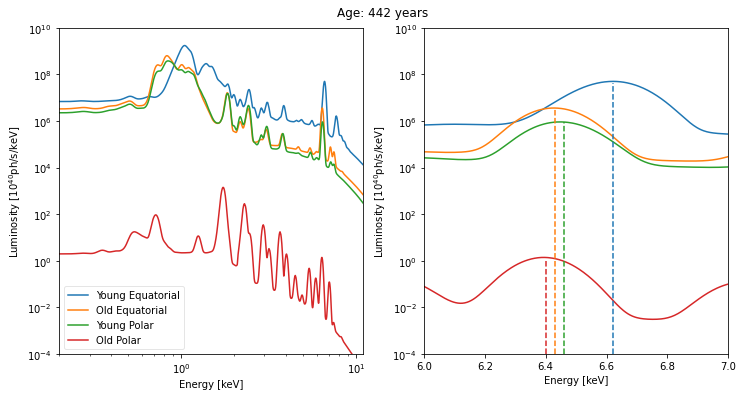

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
for wind,label in zip(['wind_eq','wind_eq_old','wind_po','wind_po_old'], ['Young Equatorial','Old Equatorial','Young Polar','Old Polar']):
    path = os.getcwd() + '/sch115/' + wind + '/' #* Change this based on your directory
    datfile = 1060

    hstfile = path + 'snr_Ia_.hst' 
    infile  = path + 'snr_Ia_prof_a_' + str(datfile) + '.dat' #Input file: any Lagrangian profile from ChN
    outfile = path + 'sedSuzaku_snr_Ia_' + str(datfile) + '.dat' #Output file: save spectral data to an ascii file
    dat = loadtxt(outfile)
    Ec  = dat[:,0]
    lum_ej = dat[:,1] #* (1e-3)**2 # correcting the /=dE error in original write
    lum_csm = dat[:,2] #* (1e-3)**2
    lum = dat[:,3] #* (1e-3)**2
    ax1.loglog(Ec,lum_ej/1e40,label=label)
    ax2.semilogy(Ec,lum_ej/1e40,label=label)
    
ax1.set_xlim(0.2,11)
ax1.set_ylim(1e-4,1e10)
ax2.set_xlim(6,7)
ax2.set_ylim(1e-4,1e10)
ax1.set_ylabel('Luminosity [10$^{40} $ph/s/keV]')
ax1.set_xlabel('Energy [keV]')
ax2.set_ylabel('Luminosity [10$^{40} $ph/s/keV]')
ax2.set_xlabel('Energy [keV]')
fig.suptitle('Age: 442 years',x=0.5,y=0.93)

ax2.axvline(6.62,ls='--',color='tab:blue',ymax=0.83)
ax2.axvline(6.43,ls='--',color='tab:orange',ymax=0.75)
ax2.axvline(6.46,ls='--',color='tab:green',ymax=0.71)
ax2.axvline(6.4, ls='--',color='tab:red',ymax=0.29) 

ax1.legend(fancybox=True, framealpha=0.5)
fig.savefig('luminosity_centroids.pdf')